In [ ]:
from google.colab import drive #1
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
DATASET_ROOT = "/content/drive/MyDrive/<YOUR_SHORTCUT_FOLDER_NAME>"
#2

In [ ]:
!pip -q install gdown #3


In [ ]:
import os
os.listdir("/content/drive/MyDrive/data")
#4


['building', 'car', 'lab', 'person', 'tree']

In [ ]:
import os, glob #5

DATA_ROOT = "/content/drive/MyDrive/data"  # <- your shortcut folder
print("DATA_ROOT exists?", os.path.exists(DATA_ROOT))
print("Folders (classes):", sorted([d for d in os.listdir(DATA_ROOT) if os.path.isdir(os.path.join(DATA_ROOT,d))]))

# count images per class
exts = (".jpg", ".jpeg", ".png", ".bmp", ".webp")
for cls in sorted(os.listdir(DATA_ROOT)):
    p = os.path.join(DATA_ROOT, cls)
    if os.path.isdir(p):
        n = sum(1 for f in os.listdir(p) if f.lower().endswith(exts))
        print(f"{cls:10s} -> {n} images")


DATA_ROOT exists? True
Folders (classes): ['building', 'car', 'lab', 'person', 'tree']
building   -> 339 images
car        -> 449 images
lab        -> 230 images
person     -> 320 images
tree       -> 517 images


In [ ]:
import tensorflow as tf #6
import os

SPLIT_ROOT = "/content/drive/MyDrive/data_split"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE


In [ ]:
import os, shutil, random #7
from pathlib import Path

# SOURCE (Google Drive shortcut)
DATA_ROOT = "/content/drive/MyDrive/data"

# DESTINATION (local, fast)
SPLIT_ROOT = "/content/drive/MyDrive/data_split"

TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

SEED = 42
random.seed(SEED)

print("DATA_ROOT exists?", os.path.exists(DATA_ROOT))
print("Classes:", os.listdir(DATA_ROOT))


DATA_ROOT exists? True
Classes: ['building', 'car', 'lab', 'person', 'tree', 'split']


In [ ]:
if os.path.exists(SPLIT_ROOT): #8
    shutil.rmtree(SPLIT_ROOT)

for split in ["train", "val", "test"]:
    for cls in os.listdir(DATA_ROOT):
        os.makedirs(os.path.join(SPLIT_ROOT, split, cls), exist_ok=True)

print("✅ Empty split folders created")


✅ Empty split folders created


In [ ]:
def split_class(class_name): #9
    src = Path(DATA_ROOT) / class_name
    images = list(src.glob("*"))
    random.shuffle(images)

    n = len(images)
    n_train = int(n * TRAIN_RATIO)
    n_val = int(n * VAL_RATIO)

    splits = {
        "train": images[:n_train],
        "val": images[n_train:n_train+n_val],
        "test": images[n_train+n_val:]
    }

    for split, files in splits.items():
        for f in files:
            dst = Path(SPLIT_ROOT) / split / class_name / f.name
            shutil.copy(f, dst)

    return {k: len(v) for k, v in splits.items()}

# Run split
summary = {}
for cls in os.listdir(DATA_ROOT):
    summary[cls] = split_class(cls)

print("✅ Split completed")
for cls, counts in summary.items():
    print(cls, counts)


IsADirectoryError: [Errno 21] Is a directory: '/content/drive/MyDrive/data/split/test'

In [ ]:
for split in ["train", "val", "test"]: #10
    total = 0
    print(f"\n{split.upper()}")
    for cls in os.listdir(os.path.join(SPLIT_ROOT, split)):
        count = len(os.listdir(os.path.join(SPLIT_ROOT, split, cls)))
        print(f"{cls:8s}: {count}")
        total += count
    print("Total:", total)


In [ ]:
IMG_SIZE = (224, 224) #11
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(SPLIT_ROOT, "train"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)


Found 1286 files belonging to 5 classes.


In [ ]:
from tensorflow.keras import layers, models, regularizers #13

l2 = regularizers.l2(1e-4)

model = models.Sequential([
    layers.Input(shape=(224,224,3)),
    layers.Rescaling(1./255),

    layers.Conv2D(32, 3, padding="same", activation="relu", kernel_regularizer=l2),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding="same", activation="relu", kernel_regularizer=l2),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding="same", activation="relu", kernel_regularizer=l2),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(256, 3, padding="same", activation="relu", kernel_regularizer=l2, name="last_conv_layer"),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation="softmax")
], name="HighAcc_CNN")

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "HighAcc_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv_layer (Conv2D)        │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 391,621 (1.49 MB)

 Trainable params: 390,661 (1.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
callbacks = [ #14
    tf.keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_accuracy", mode="max"),
    tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True, monitor="val_accuracy"),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, monitor="val_loss")
]

history = model.fit(
    train_ds_aug,
    validation_data=val_ds,
    epochs=40,
    callbacks=callbacks
)


Epoch 1/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 428s 8s/step - accuracy: 0.4990 - loss: 1.3476 - val_accuracy: 0.1701 - val_loss: 2.0785 - learning_rate: 0.0010
Epoch 2/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 310s 7s/step - accuracy: 0.6571 - loss: 0.9451 - val_accuracy: 0.1701 - val_loss: 2.5625 - learning_rate: 0.0010
Epoch 3/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 327s 7s/step - accuracy: 0.6571 - loss: 0.9735 - val_accuracy: 0.1701 - val_loss: 2.8597 - learning_rate: 0.0010
Epoch 4/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 322s 7s/step - accuracy: 0.7248 - loss: 0.7870 - val_accuracy: 0.1944 - val_loss: 2.7581 - learning_rate: 5.0000e-04
Epoch 5/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 287s 7s/step - accuracy: 0.7450 - loss: 0.7069 - val_accuracy: 0.2292 - val_loss: 2.9554 - learning_rate: 5.0000e-04
Epoch 6/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 323s 7s/step - accuracy: 0.7755 - loss: 0.6973 - val_accuracy: 0.2292 - val_loss: 2.7274 - learning_rate: 2.5000e-04
Epoch 7/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 287s 7s/step - accuracy: 0.7814 - loss: 0.61

In [ ]:
test_loss, test_acc = model.evaluate(test_ds) #15
print("Test accuracy:", test_acc)


9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.6502 - loss: 0.8544
Test accuracy: 0.7615658640861511


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


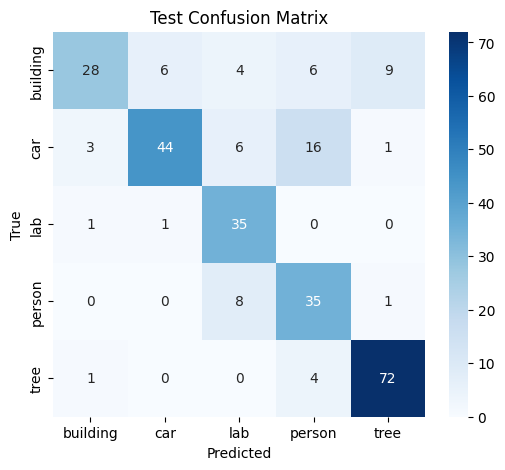

In [ ]:
import numpy as np #19
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_true, y_pred = [], []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Test Confusion Matrix")
plt.show()


In [ ]:
import numpy as np #20
import tensorflow as tf

NUM_WRONG = 6   # how many misclassified examples you want to show

wrong_samples = []  # will store (img, true_label, pred_label, confidence)

for images, labels in test_ds:
    probs = model.predict(images, verbose=0)          # (batch, 5)
    preds = np.argmax(probs, axis=1)

    for i in range(len(labels)):
        true = int(labels[i].numpy())
        pred = int(preds[i])
        conf = float(np.max(probs[i]))

        if pred != true:
            wrong_samples.append((images[i], true, pred, conf))
            if len(wrong_samples) >= NUM_WRONG:
                break
    if len(wrong_samples) >= NUM_WRONG:
        break

print("Misclassified samples collected:", len(wrong_samples))
for k, (_, t, p, conf) in enumerate(wrong_samples):
    print(f"{k}: True={class_names[t]} | Pred={class_names[p]} | Conf={conf:.2f}")


Misclassified samples collected: 6
0: True=building | Pred=tree | Conf=0.73
1: True=building | Pred=car | Conf=0.66
2: True=building | Pred=car | Conf=0.66
3: True=building | Pred=car | Conf=0.55
4: True=building | Pred=person | Conf=0.88
5: True=building | Pred=tree | Conf=0.95


In [ ]:
_ = model(tf.zeros((1, 224, 224, 3)), training=False)#23


In [ ]:
import tensorflow as tf #27

last_conv_layer_name = "last_conv_layer"

inputs = tf.keras.Input(shape=(224, 224, 3))
x = inputs
conv_out = None

for layer in model.layers:
    x = layer(x)
    if layer.name == last_conv_layer_name:
        conv_out = x

grad_model = tf.keras.Model(inputs=inputs, outputs=[conv_out, x])
print("Grad-CAM wrapper built ✅")


Grad-CAM wrapper built ✅


Collected wrong samples: 6


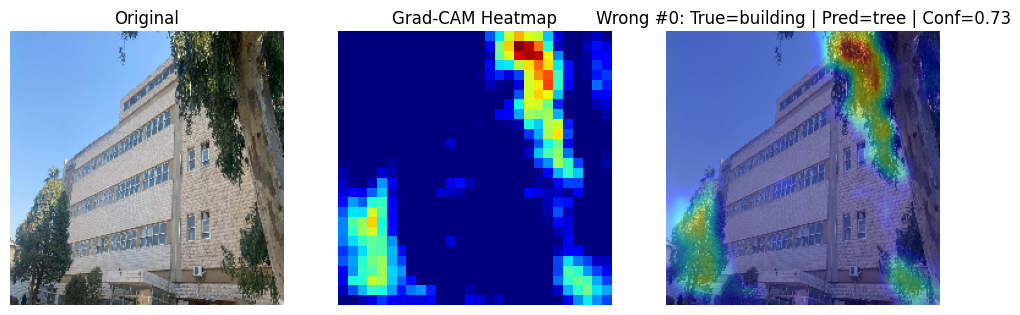

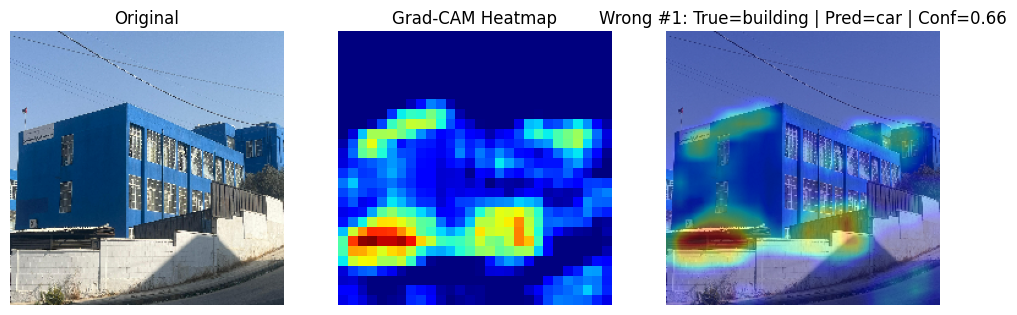

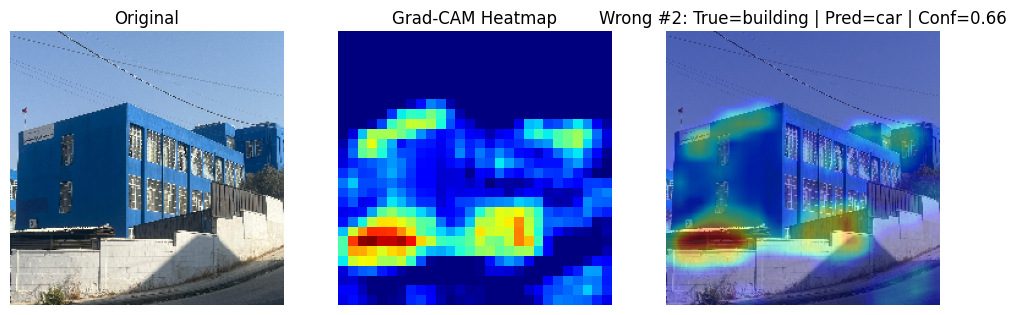

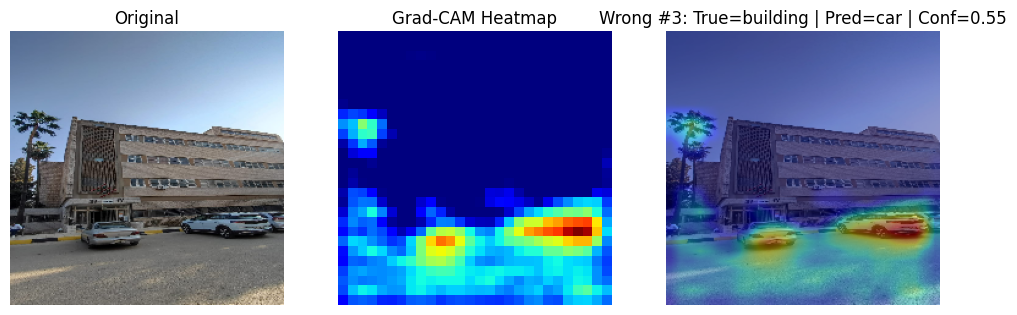

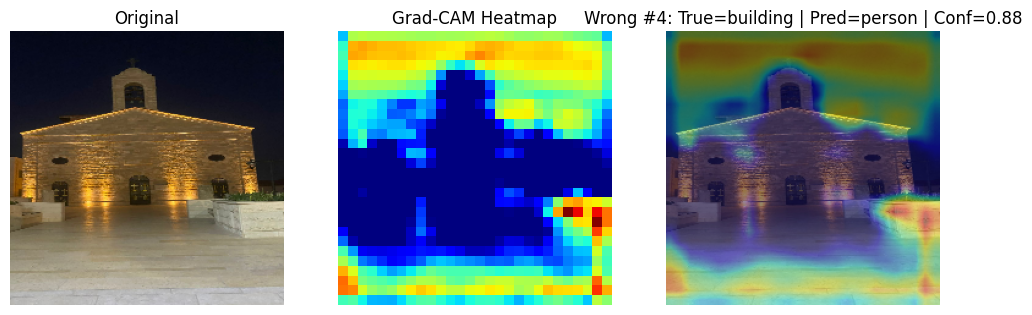

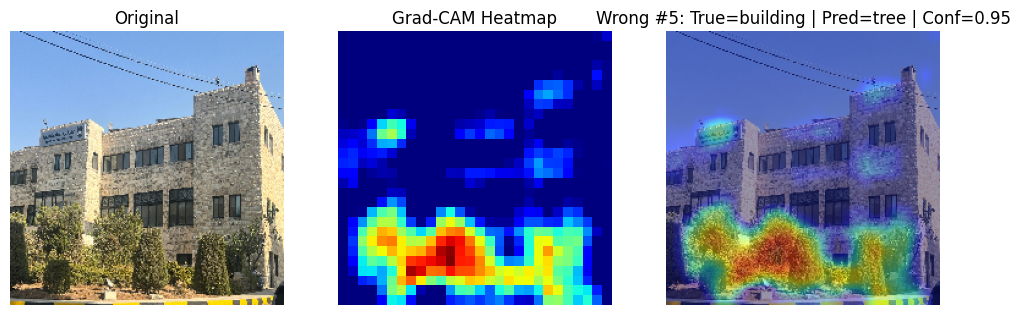

In [ ]:
import tensorflow as tf #29
import numpy as np
import matplotlib.pyplot as plt

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    with tf.GradientTape() as tape:
        x = img_array
        conv_outputs = None

        # Perform the forward pass layer by layer to capture intermediate outputs
        for layer in model.layers:
            x = layer(x)
            if layer.name == last_conv_layer_name:
                conv_outputs = x
                # Explicitly watch the output of the last convolutional layer
                tape.watch(conv_outputs)

        predictions = x # Final output of the model

        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute the gradient of the top predicted class with respect to the
    # activations of the last conv layer
    grads = tape.gradient(class_channel, conv_outputs)

    # Handle cases where gradients might be None (e.g., disconnected graph)
    if grads is None:
        # This could happen if conv_outputs was not watched, or if there's no differentiable path.
        # Given the explicit tape.watch, this should be rare if the model is differentiable.
        print("Warning: Gradients are None. Check make_gradcam_heatmap implementation or model differentiability.")
        return np.zeros(conv_outputs.shape[1:3]), -1 # Return a black heatmap and invalid prediction

    # Mean intensity of the gradient over the feature map channels
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map by the importance weight
    # calculated by `pooled_grads`
    heatmap = conv_outputs[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap to be in the range [0, 1]
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy(), int(pred_index.numpy())

last_conv_layer_name = "last_conv_layer"
NUM_WRONG = 6

wrong_samples = []

# Collect misclassified examples from test set
for images, labels in test_ds:
    probs = model.predict(images, verbose=0)
    preds = np.argmax(probs, axis=1)

    for i in range(len(labels)):
        true = int(labels[i].numpy())
        pred = int(preds[i])
        conf = float(np.max(probs[i]))

        if pred != true:
            wrong_samples.append((images[i], true, pred, conf))
            if len(wrong_samples) >= NUM_WRONG:
                break
    if len(wrong_samples) >= NUM_WRONG:
        break

print("Collected wrong samples:", len(wrong_samples))

# Show Grad-CAM for each wrong sample
for k, (img, true, pred, conf) in enumerate(wrong_samples):
    img_batch = tf.expand_dims(img, axis=0)

    heatmap, _ = make_gradcam_heatmap(img_batch, model, last_conv_layer_name)

    img_np = img.numpy().astype("uint8")
    heatmap_resized = tf.image.resize(
        heatmap[..., np.newaxis],
        (img_np.shape[0], img_np.shape[1])
    ).numpy().squeeze()

    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img_np); plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(heatmap, cmap="jet"); plt.axis("off")

    plt.subplot(1,3,3)
    plt.title(f"Wrong #{k}: True={class_names[true]} | Pred={class_names[pred]} | Conf={conf:.2f}")
    plt.imshow(img_np)
    plt.imshow(heatmap_resized, cmap="jet", alpha=0.4)
    plt.axis("off")

    plt.show()